In [1]:
import numpy as np
import pandas as pd
data=np.load("week_11_data/second_batch_test_with_labels.npz")

X = data["X"]
y = data["y"]

In [2]:
XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
print("# of items:", XX['item'].unique().shape[0])

# of items: 1192


In [3]:
yy.rename(columns={0:"user",1:"label"},inplace=True)
yy.head()

,user,label
0,3000,1
1,3001,0
2,3002,0
3,3003,0
4,3004,0


In [4]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils import class_weight
from tensorflow.keras import regularizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

/Users/timothylee/Library/Python/3.10/lib/python/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [10]:
merged_data = pd.merge(XX, yy, on='user', how='left')
merged_data.head()

,user,item,rating,label
0,4093,75,5,0
1,4093,262,4,0
2,4093,331,4,0
3,4093,380,2,0
4,4093,381,2,0


In [11]:
len(merged_data["user"].unique())

1220

In [19]:
groups_X = merged_data.groupby('user')
groups_X = [group for _, group in groups_X]

In [20]:
from scipy.stats import entropy

# Feature Engineering
features_list = []

for group in groups_X:
    user = group['user'].iloc[0]
    label = group['label'].iloc[0] 
    min_rating = group['rating'].min()
    total_interactions = group.shape[0]
    rating_range = (group['rating'].max() - group['rating'].min())
    unique_items = group['item'].nunique()
    ratings_count = group['rating'].value_counts(normalize=True)
    ratings_entropy = entropy(ratings_count)
    item_diversity = group['item'].nunique() / merged_data['item'].nunique()
    proportion_of_5_stars = (group['rating'] == 5).sum() / group.shape[0]
    proportion_of_1_star = (group['rating'] == 1).sum() / group.shape[0]
    mode_count = group['rating'].value_counts(dropna=True).max()
    mode_ratio = mode_count / total_interactions
    median_rating = group['rating'].median()
    average_rating = group['rating'].mean()
    test = total_interactions * ratings_entropy

    score = 0
    for item in group['item']:
        score = score + item

    rating_variance = group['rating'].var()
    extreme_ratings_ratio = ((group['rating'] == 1) | (group['rating'] == 5)).sum() / total_interactions

    features_list.append({
        'user': user,
        'label': label,
        'min_rating': min_rating,
        'test': test,
        'total_interactions': total_interactions,
        'score': score,
        'rating_variance': rating_variance,
        'extreme_ratings_ratio': extreme_ratings_ratio,
        'ratings_entropy': ratings_entropy,
        'mode_ratio': mode_ratio,
        'average_rating': average_rating,
        # 'median_rating': median_rating,
        # 'rating_range': rating_range,
        # 'unique_items': unique_items,
        # 'item_diversity': item_diversity,
        # 'proportion_of_5_stars': proportion_of_5_stars,
        # 'proportion_of_1_star': proportion_of_1_star,
    })

# Create a DataFrame with the features
features_df = pd.DataFrame(features_list)
min_rating_1 = features_df['min_rating'] == 1
features_df['min_rating_1'] = min_rating_1.astype(int)
features_df.head()

,user,label,min_rating,test,total_interactions,score,rating_variance,extreme_ratings_ratio,ratings_entropy,mode_ratio,average_rating,min_rating_1
0,3000,1,1,254.920874,201,106453,0.805274,0.094527,1.268263,0.422886,3.243781,1
1,3001,0,2,123.553982,116,35151,0.584108,0.439655,1.065121,0.439655,4.275862,0
2,3002,0,0,420.763630,361,154273,0.709234,0.063712,1.165550,0.432133,3.409972,0
3,3003,0,1,147.198711,101,12108,1.451683,0.316832,1.457413,0.386139,3.356436,1
4,3004,0,3,8.932196,13,6781,0.397436,0.769231,0.687092,0.769231,4.692308,0


In [23]:
# Define thresholds
rare_threshold = 400  
disliked_threshold = 4 

# Calculate the count of ratings per item
item_counts = merged_data['item'].value_counts()

# Find rare items based on the threshold
rare_items = item_counts[item_counts < rare_threshold].index

# Calculate average rating per item
item_avg_rating = merged_data.groupby('item')['rating'].mean()

# Find disliked items based on the threshold
disliked_items = item_avg_rating[item_avg_rating < disliked_threshold].index

# Mark interactions with rare and disliked items
merged_data['rare_interaction'] = merged_data['item'].isin(rare_items).astype(int)
merged_data['disliked_interaction'] = merged_data['item'].isin(disliked_items).astype(int)

# Calculate the mean proportion of rare and disliked interactions per user
user_rare_disliked_interaction = merged_data.groupby('user').agg({
    'rare_interaction': 'mean',  # Proportion of interactions with rarely rated items
    'disliked_interaction': 'mean'  # Proportion of interactions with disliked items

}).reset_index()

features_df = features_df.merge(user_rare_disliked_interaction, on='user', how='left')

item_variance = merged_data.groupby('item')['rating'].var().reset_index(name='item_variance')
merged_data_var = merged_data.merge(item_variance, on='item', how='left')

user_avg_item_variance = merged_data_var.groupby('user')['item_variance'].mean().reset_index(name='avg_item_variance')

# Merge this new feature into features_df
features_df = features_df.merge(user_avg_item_variance, on='user', how='left')

# features_df.drop(columns=['user'], inplace=True)

In [24]:
features_df.head()

,user,label,min_rating,test,total_interactions,score,rating_variance,extreme_ratings_ratio,ratings_entropy,mode_ratio,average_rating,min_rating_1,rare_interaction_x,disliked_interaction_x,avg_item_variance_x,rare_interaction_y,disliked_interaction_y,avg_item_variance_y
0,3000,1,1,254.920874,201,106453,0.805274,0.094527,1.268263,0.422886,3.243781,1,0.706468,0.970149,0.974963,0.706468,0.970149,0.974963
1,3001,0,2,123.553982,116,35151,0.584108,0.439655,1.065121,0.439655,4.275862,0,0.603448,0.931034,0.953317,0.603448,0.931034,0.953317
2,3002,0,0,420.763630,361,154273,0.709234,0.063712,1.165550,0.432133,3.409972,0,0.698061,0.972299,0.992915,0.698061,0.972299,0.992915
3,3003,0,1,147.198711,101,12108,1.451683,0.316832,1.457413,0.386139,3.356436,1,0.673267,0.980198,1.007199,0.673267,0.980198,1.007199
4,3004,0,3,8.932196,13,6781,0.397436,0.769231,0.687092,0.769231,4.692308,0,1.000000,1.000000,0.920432,1.000000,1.000000,0.920432


In [29]:
features_df[
    (features_df['label'] == 0) & (features_df['min_rating'] == 0)
].shape[0]

362

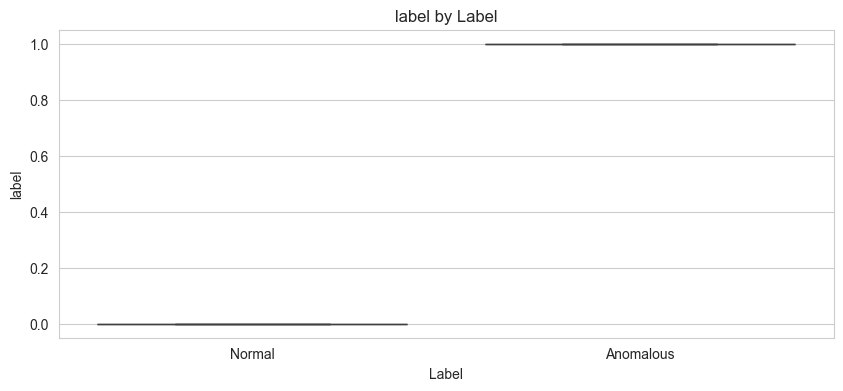

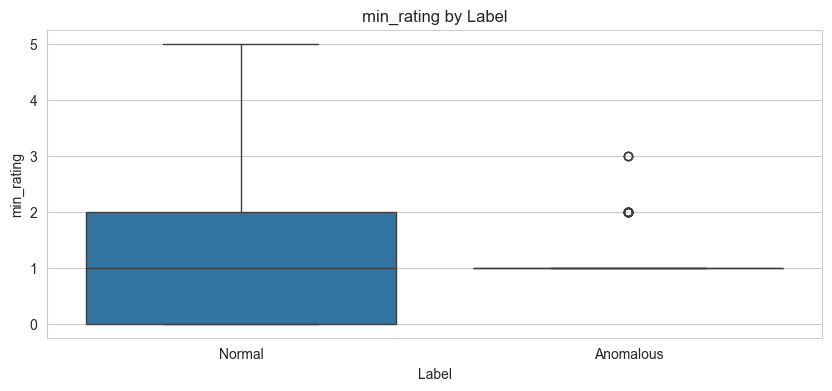

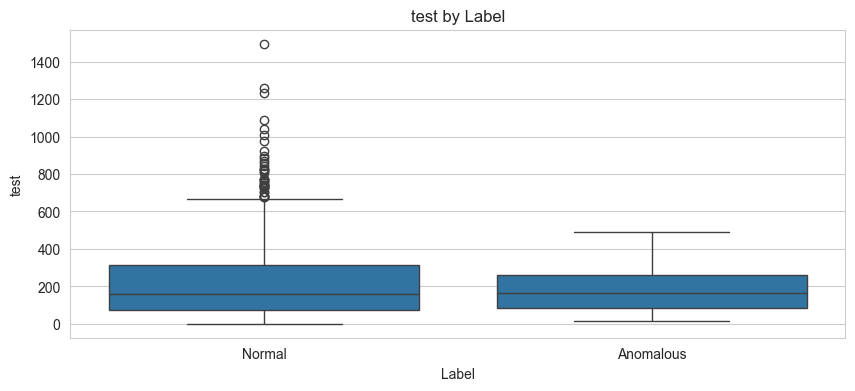

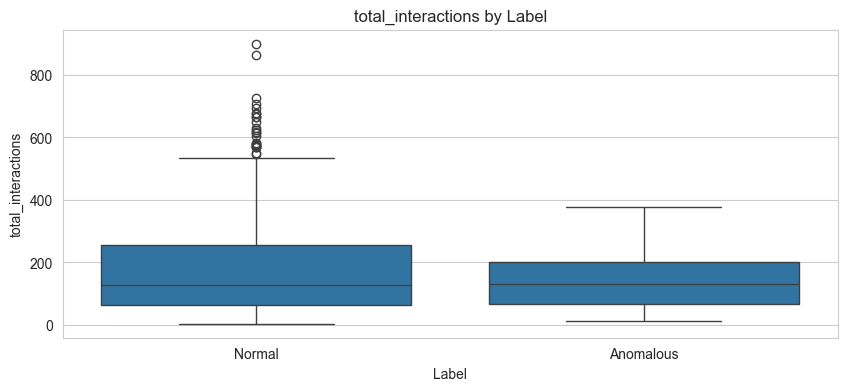

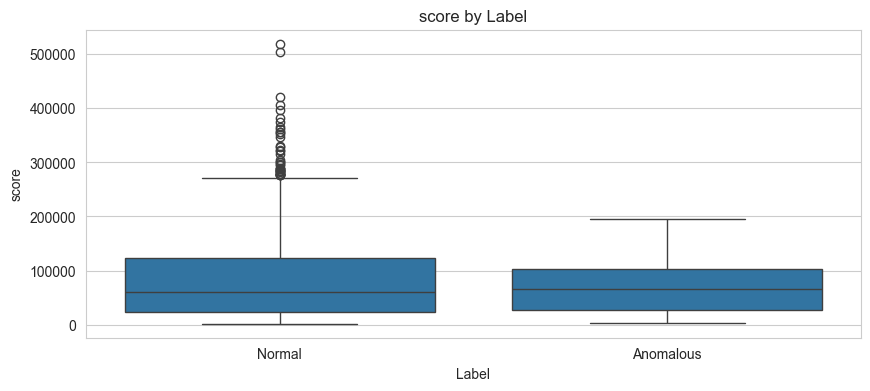

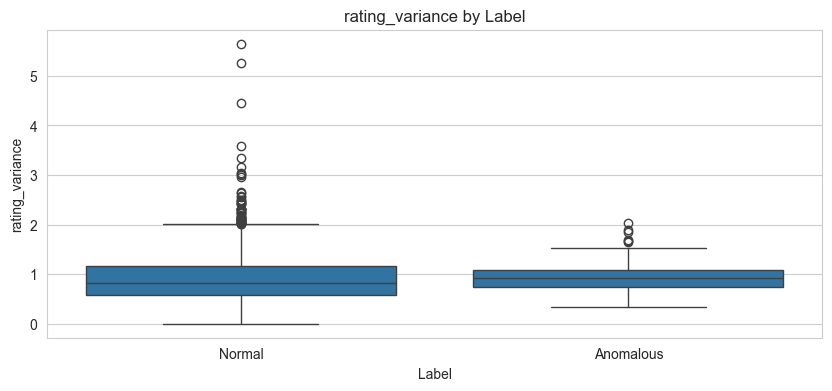

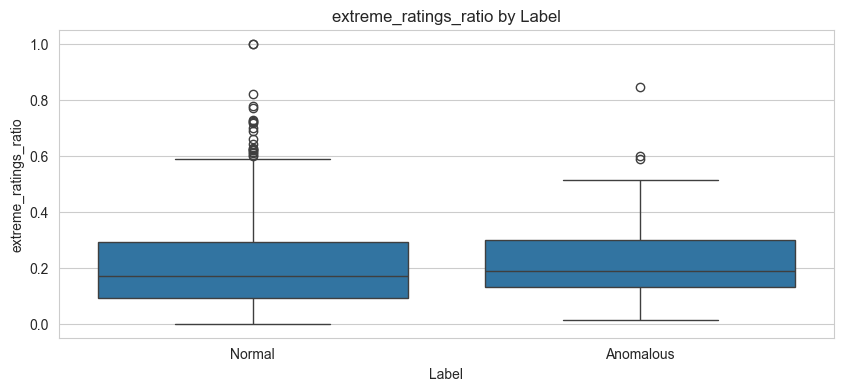

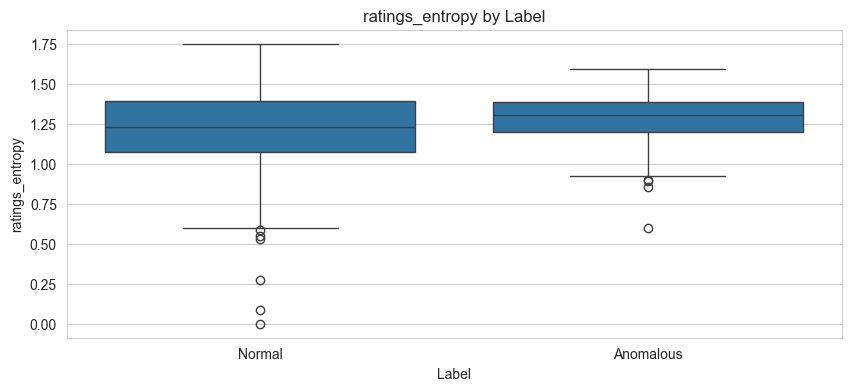

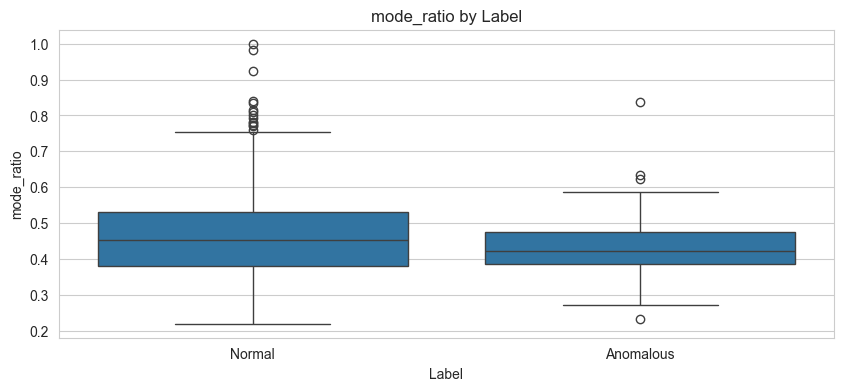

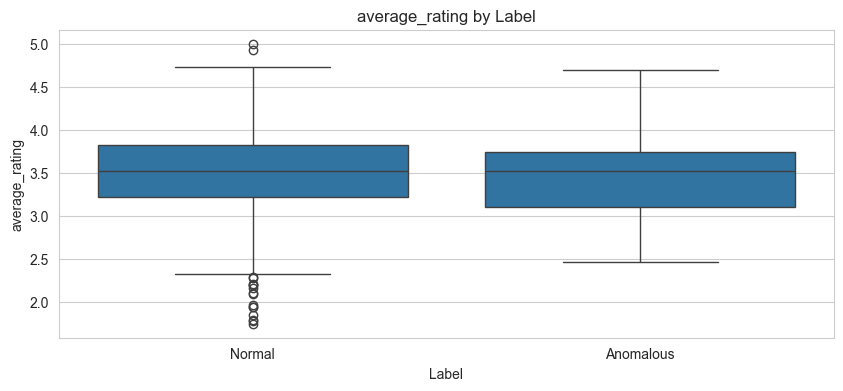

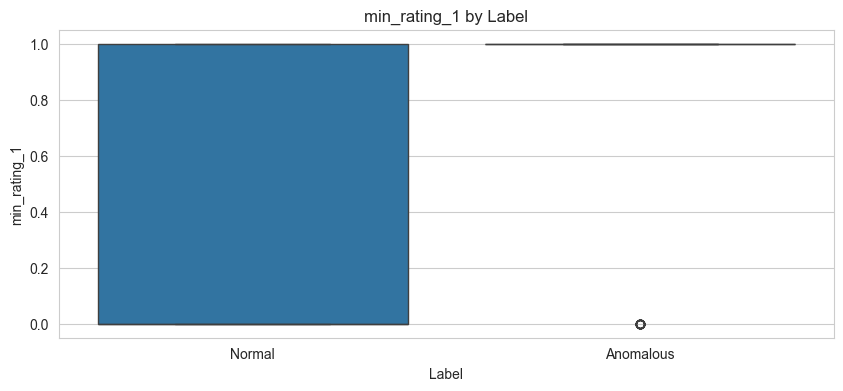

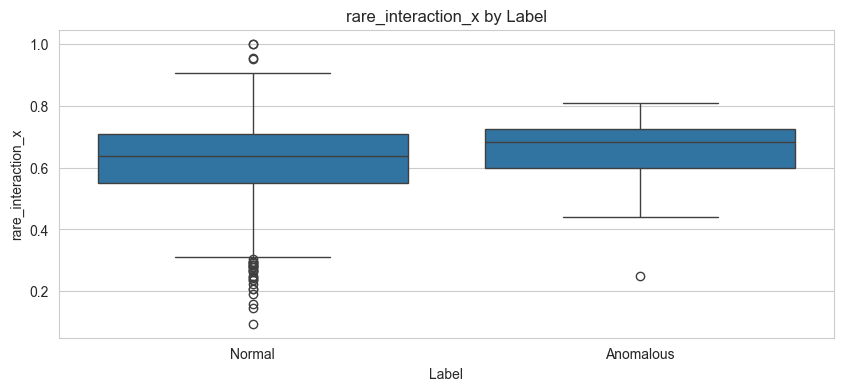

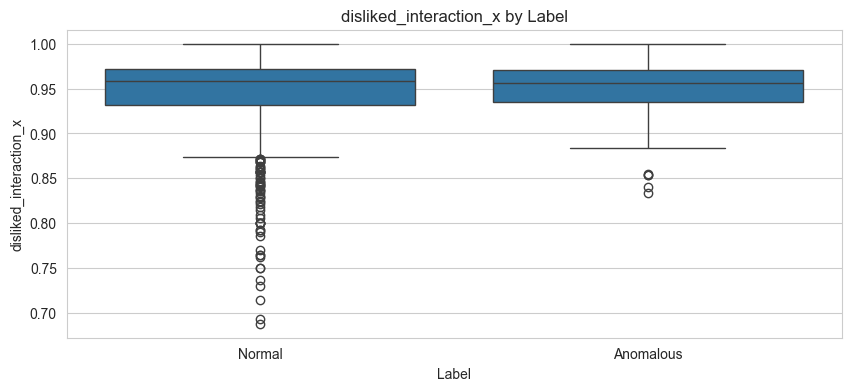

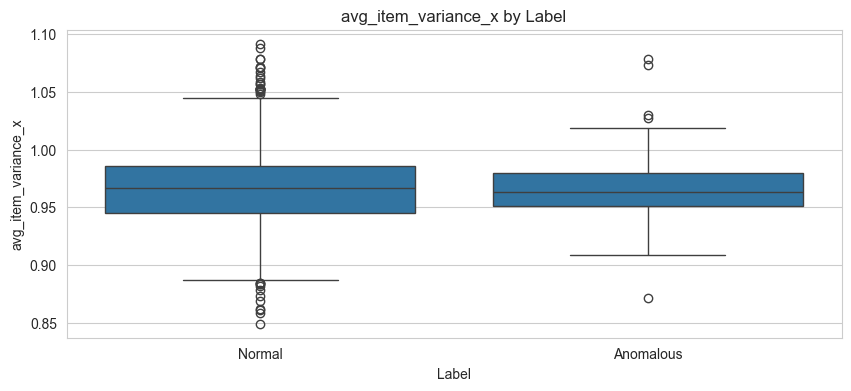

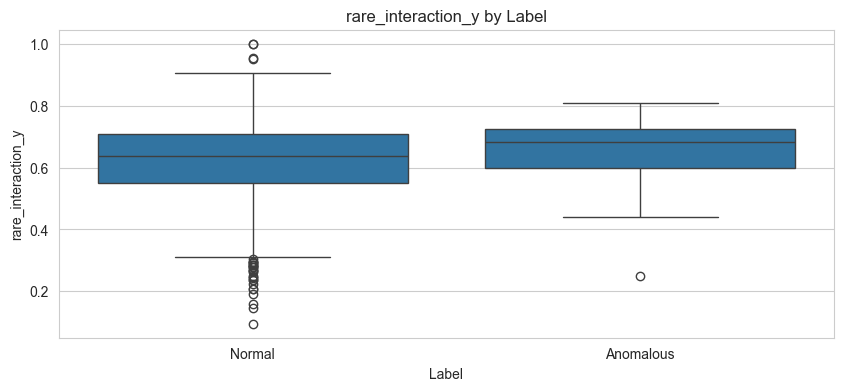

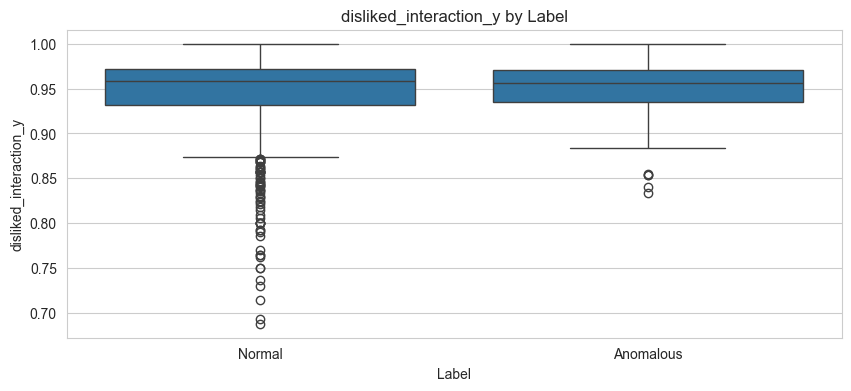

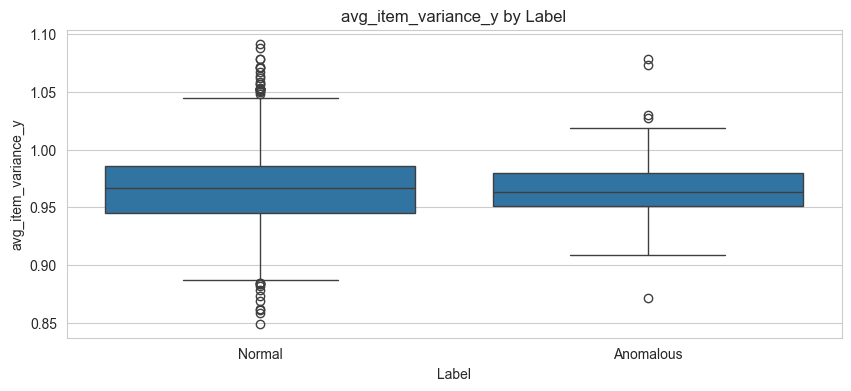

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot boxplots
for feature in features_df.columns[1:]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='label', y=feature, data=features_df)
    plt.title(f'{feature} by Label')
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Normal', 'Anomalous'])
    plt.show()